In [1]:
%pip install zoopt
%pip install pandas
%pip install -U scikit-learn
%pip install seaborn


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
  Using cached scikit_learn-1.5.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (12 kB)
  Using cached scipy-1.14.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
Using cached scikit_learn-1.5.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.4 MB)
Using cached scipy-1.14.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (41.2 MB)

[

In [1]:
import os
import itertools
import logging

import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from zoopt import Dimension, Objective, Parameter, Opt

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, BatchNormalization, RandomFlip, RandomRotation
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB3


2024-08-29 09:33:23.425132: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-29 09:33:23.497737: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-29 09:33:23.533034: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-29 09:33:23.543865: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-29 09:33:23.593527: I tensorflow/core/platform/cpu_feature_guar

In [2]:
print(tf.__version__)

2.17.0


In [4]:
# Disable TensorFlow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Suppress TensorFlow warnings
tf.get_logger().setLevel(logging.ERROR)

In [3]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 10
K = 5

In [ ]:
tf.config.experimental.list_logical_devices

In [4]:
def loading_data(dataset_path):
    filepaths = []
    labels = []

    folds = os.listdir(dataset_path)
    for fold in folds:
        foldpath = os.path.join(dataset_path, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)

    Fseries = pd.Series(filepaths, name='filepath')
    Lseries = pd.Series(labels, name='labels')

    df = pd.concat([Fseries, Lseries], axis=1)
    return df

In [5]:
def change_label_name(df, column_name):
    index = {'normal': 'Normal', 'bact_pneumo': 'Bacterial_Pneumonia', 'viral_pneumo': 'Virus_Pneumonia'}
    df[column_name] = df[column_name].replace(index)

In [7]:
dataset_path = "/home/idrone2/Desktop/chest_xray"
df = loading_data(dataset_path)

image_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    seed=123,
    shuffle=True,
    image_size=(256, 256),  # Example size, replace with your actual IMAGE_SIZE
    batch_size=32  # Example size, replace with your actual BATCH_SIZE
)

change_label_name(df, 'labels')
df

Found 5856 files belonging to 3 classes.


,filepath,labels
0,/home/idrone2/Desktop/chest_xray/bact_pneumo/p...,Bacterial_Pneumonia
1,/home/idrone2/Desktop/chest_xray/bact_pneumo/p...,Bacterial_Pneumonia
2,/home/idrone2/Desktop/chest_xray/bact_pneumo/p...,Bacterial_Pneumonia
3,/home/idrone2/Desktop/chest_xray/bact_pneumo/p...,Bacterial_Pneumonia
4,/home/idrone2/Desktop/chest_xray/bact_pneumo/p...,Bacterial_Pneumonia
...,...,...
5851,/home/idrone2/Desktop/chest_xray/normal/NORMAL...,Normal
5852,/home/idrone2/Desktop/chest_xray/normal/NORMAL...,Normal
5853,/home/idrone2/Desktop/chest_xray/normal/NORMAL...,Normal
5854,/home/idrone2/Desktop/chest_xray/normal/IM-069...,Normal


In [8]:
class_names = image_dataset.class_names

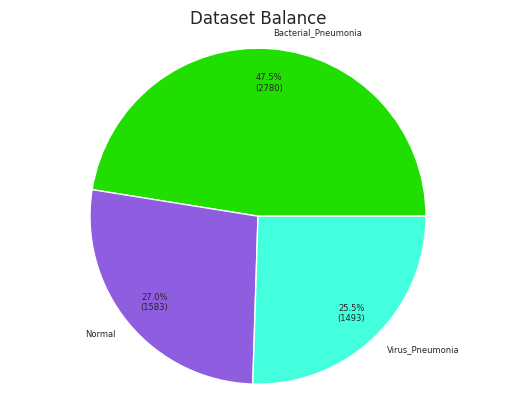

In [9]:
data_balance = df.labels.value_counts()

def custom_autopct(pct):
    total = sum(data_balance)
    val = int(round(pct*total/100.0))
    return "{:.1f}%\n({:d})".format(pct, val)

colors = ['#20df00', '#8f5ddf', '#44ffdd']
plt.pie(data_balance, autopct=custom_autopct, labels=data_balance.index, colors=colors, textprops={'fontsize':6}, pctdistance=0.8, labeldistance=1.1)
plt.title("Dataset Balance")
plt.axis("equal")
plt.show()

In [10]:
# K-Fold Cross Validation
kf = KFold(n_splits=K, shuffle=True, random_state=123)

for fold, (train_index, test_index) in enumerate(kf.split(df)):
    train_df = df.iloc[train_index]
    test_df = df.iloc[test_index]

    valid_df, test_df = train_test_split(test_df, test_size=0.8)

In [12]:
# Prepare data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
])

In [13]:
# Function to convert TensorFlow dataset to NumPy arrays
def dataset_to_numpy(dataset):
    images = []
    labels = []
    for image_batch, label_batch in dataset:
        images.append(image_batch.numpy())
        labels.append(label_batch.numpy())
    return np.concatenate(images), np.concatenate(labels)

# Assuming image_dataset is the TensorFlow dataset created earlier
images, labels = dataset_to_numpy(image_dataset)

print(images.shape, labels.shape)

2024-08-29 09:43:44.155745: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


(5856, 256, 256, 3) (5856,)


In [14]:
def preprocess(ds):
    return ds.map(
        lambda x, y: (data_augmentation(x, training=True), y)
    ).prefetch(buffer_size=tf.data.AUTOTUNE)

In [15]:
def create_model(filters_1, filters_2, units, learning_rate):
    model = models.Sequential([
        layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
        layers.experimental.preprocessing.Rescaling(1./255),
        layers.Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(len(class_names), activation='softmax'),
    ])
    
    model.compile(
        optimizer='adam',
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=['accuracy']
    )
    
    return model

In [17]:
# Zoopt Hyperparameter Optimization
def cnn_fitness(solution):
    params = solution.get_x()
    EPOCHS = int(params[0])
    filters_1 = int(params[1])
    filters_2 = int(params[2])
    units = int(params[3])
    learning_rate = params[4]
    _

    accuracy = []
    
    for train_index, val_index in KFold(n_splits=K, shuffle=True, random_state=123).split(images):
        print(f"Training fold with {EPOCHS} epochs, filters_1: {filters_1}, filters_2: {filters_2}, units: {units}, learning_rate: {learning_rate}...")
        train_images, val_images = images[train_index], images[val_index]
        train_labels, val_labels = labels[train_index], labels[val_index]
        
        train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).batch(BATCH_SIZE)
        val_ds = tf.data.Dataset.from_tensor_slices((val_images, val_labels)).batch(BATCH_SIZE)
        
        train_ds = preprocess(train_ds)
        val_ds = preprocess(val_ds)
        
        model = create_model(filters_1, filters_2, units, learning_rate)
        
        history = model.fit(
            train_ds,
            epochs=EPOCHS,
            validation_data=val_ds,
            verbose=0
        )
        
        accuracy.append(history.history['val_accuracy'][-1])
    
    return -np.mean(accuracy)

dim = Dimension(5, 
                [
                    [5, 50],
                    [32, 128],
                    [32, 128],
                    [32, 256],
                    [1e-3, 0.1]
                 ], 
                [True, True, True, True, True])  # Adjust the range of hyperparameters

objective = Objective(cnn_fitness, dim)

# Set the optimization parameters
parameter = Parameter(budget=20, intermediate_result=True)

print("Starting optimization...")
# Perform the optimization
solution = Opt.min(objective, parameter)
print("Best hyperparameters: ", solution.get_x())
print("Best validation accuracy: ", -solution.get_value())

# Train final model with optimized hyperparameters
best_params = solution.get_x()
best_epochs = int(best_params[0])
best_filters_1 = int(best_params[1])
best_filters_2 = int(best_params[2])
best_units = int(best_params[3])
best_learning_rate = best_params[4]

print("Training final model with best parameters...")
# Example: Train final model with the best parameters
final_model = create_model(best_filters_1, best_filters_2, best_units, best_learning_rate)
history = final_model.fit(
    preprocess(image_dataset),
    epochs=best_epochs,
    verbose=1,
)
print("Training complete.")

Starting optimization...
Training fold with 23 epochs, filters_1: 54, filters_2: 82, units: 158, learning_rate: 0.09433248849686238...


2024-08-29 09:49:45.278391: W external/local_tsl/tsl/framework/bfc_allocator.cc:482] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.43GiB (rounded to 3683647488)requested by op _EagerConst
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2024-08-29 09:49:45.278408: I external/local_tsl/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2024-08-29 09:49:45.278412: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 11, Chunks in use: 11. 2.8KiB allocated for chunks. 2.8KiB in use in bin. 97B client-requested in use in bin.
2024-08-29 09:49:45.278414: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 0, Chunks in use: 0. 0B allocated for chunks. 0B in use in bin. 0B client-requested in use in bin.
2024-08-29 09:49:45.278416: I external/l

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [55]:
print(history.history.keys())

dict_keys(['loss', 'accuracy'])


In [70]:
def load_and_preprocess_image(filepath):
    image = tf.io.read_file(filepath)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])
    image = image / 255.0  # Normalize to [0,1]
    return image

In [71]:
# Create label_map from class names
class_names = ['Normal', 'Bacterial_Pneumonia', 'Virus_Pneumonia', ...]  # replace with your actual class names
label_map = {name: index for index, name in enumerate(class_names)}


In [72]:
# Function to preprocess dataset
def preprocess_dataset(df):
    filepaths = df['filepath'].values
    labels = df['labels'].values




    images = np.array([load_and_preprocess_image(fp) for fp in filepaths])
    labels = np.array([label_map[label] for label in labels])
    dataset = tf.data.Dataset.from_tensor_slices((images, labels)).batch(BATCH_SIZE)
    return dataset

# Preprocess all datasets
train_ds = preprocess_dataset(train_df)
valid_ds = preprocess_dataset(valid_df)
test_ds = preprocess_dataset(test_df)

In [73]:
# Evaluate on test dataset
test_loss, test_accuracy = final_model.evaluate(test_ds, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Evaluate on training dataset
train_loss, train_accuracy = final_model.evaluate(train_ds, verbose=1)
print(f"Train Loss: {train_loss}")
print(f"Train Accuracy: {train_accuracy}")

# Evaluate on validation dataset
valid_loss, valid_accuracy = final_model.evaluate(valid_ds, verbose=1)
print(f"Validation Loss: {valid_loss}")
print(f"Validation Accuracy: {valid_accuracy}")

30/30 [==============================] - 1s 46ms/step - loss: 1.4374 - accuracy: 0.2700
Test Loss: 1.4374258518218994
Test Accuracy: 0.27001067996025085
147/147 [==============================] - 7s 46ms/step - loss: 1.4616 - accuracy: 0.2527
Train Loss: 1.4615846872329712
Train Accuracy: 0.2527214586734772
8/8 [==============================] - 0s 43ms/step - loss: 1.4676 - accuracy: 0.2393
Validation Loss: 1.4675729274749756
Validation Accuracy: 0.23931623995304108


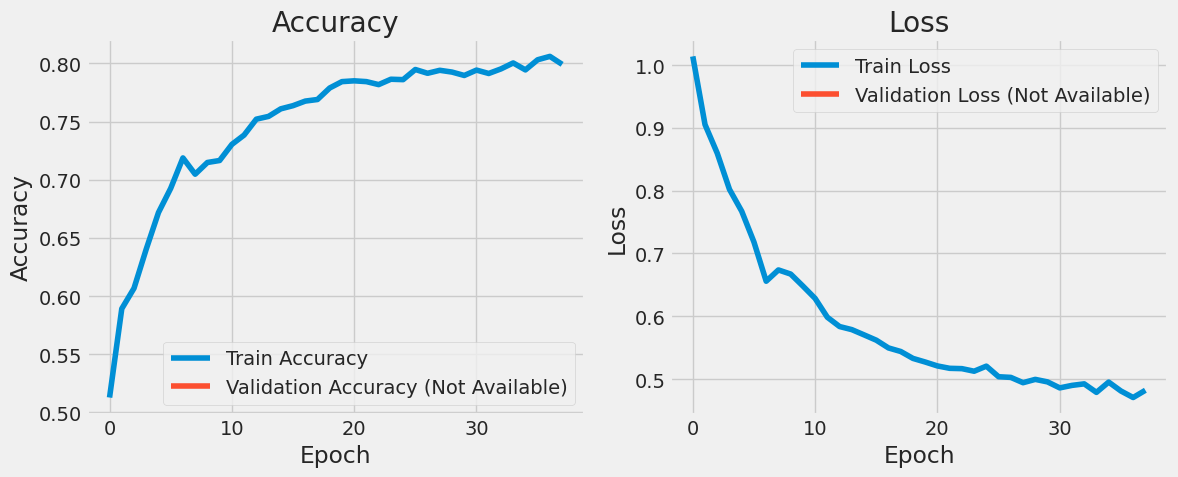

In [75]:
def plot_history(history):
    plt.figure(figsize=(12, 5))

    # Plot Training and Validation Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    if 'val_accuracy' in history.history:
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    else:
        plt.plot([], [], label='Validation Accuracy (Not Available)')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Training and Validation Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Validation Loss')
    else:
        plt.plot([], [], label='Validation Loss (Not Available)')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Assuming `history` is the result of model.fit() with validation data
plot_history(history)

In [69]:
# Create test dataset from `test_df`
test_filepaths = test_df['filepath'].values
test_labels = test_df['labels'].values

# Load and preprocess test images
test_images = np.array([load_and_preprocess_image(fp) for fp in test_filepaths])
test_labels = np.array([label_map[label] for label in test_labels])

# Create TensorFlow dataset for testing
test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(BATCH_SIZE)
test_ds = preprocess(test_ds)

# Evaluate final model on the test dataset
test_loss, test_accuracy = final_model.evaluate(test_ds, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
# Evaluate final model on the test dataset
train_loss, train_accuracy = final_model.evaluate(train_df, verbose=1)
print(f"Train Loss: {train_loss}")
print(f"Train Accuracy: {train_accuracy}")
# Evaluate final model on the test dataset
valid_loss, valid_accuracy = final_model.evaluate(valid_df, verbose=1)
print(f"validation Loss: {valid_loss}")
print(f"validation Accuracy: {valid_accuracy}")

30/30 [==============================] - 3s 112ms/step - loss: 1.4414 - accuracy: 0.2700
Test Loss: 1.4414441585540771
Test Accuracy: 0.27001067996025085


ValueError: in user code:

    File "/home/idrone2/Desktop/mri_cnn/.venv/lib/python3.8/site-packages/keras/src/engine/training.py", line 1972, in test_function  *
        return step_function(self, iterator)
    File "/home/idrone2/Desktop/mri_cnn/.venv/lib/python3.8/site-packages/keras/src/engine/training.py", line 1956, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/idrone2/Desktop/mri_cnn/.venv/lib/python3.8/site-packages/keras/src/engine/training.py", line 1944, in run_step  **
        outputs = model.test_step(data)
    File "/home/idrone2/Desktop/mri_cnn/.venv/lib/python3.8/site-packages/keras/src/engine/training.py", line 1850, in test_step
        y_pred = self(x, training=False)
    File "/home/idrone2/Desktop/mri_cnn/.venv/lib/python3.8/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None

    ValueError: Exception encountered when calling layer 'resizing_100' (type Resizing).
    
    'images' must have either 3 or 4 dimensions.
    
    Call arguments received by layer 'resizing_100' (type Resizing):
      • inputs=tf.Tensor(shape=(None, 2), dtype=float32)


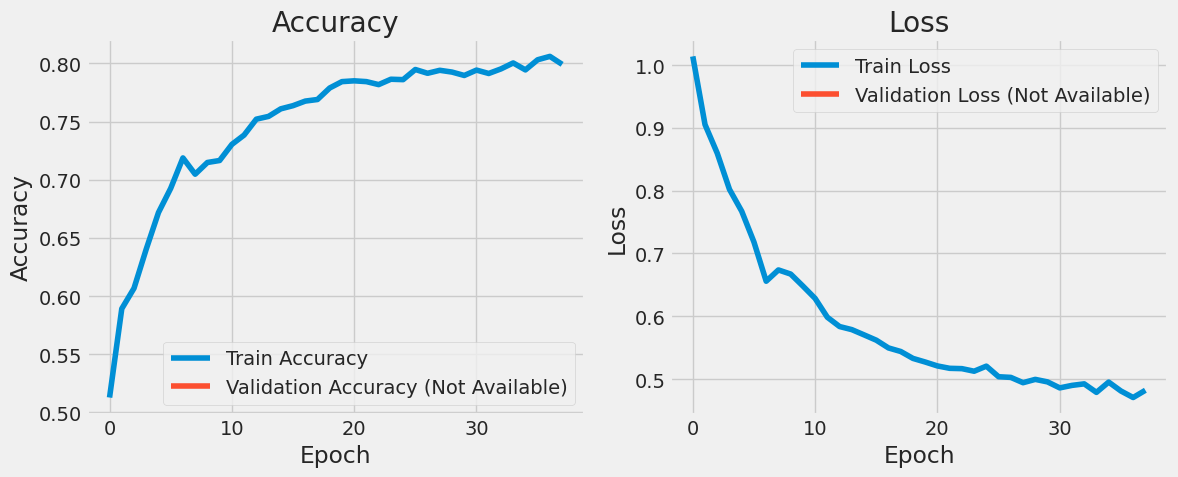

In [59]:
def plot_history(history):
    plt.figure(figsize=(12, 5))

    # Plot Training Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    if 'val_accuracy' in history.history:
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    else:
        plt.plot([], [], label='Validation Accuracy (Not Available)')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Training Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Validation Loss')
    else:
        plt.plot([], [], label='Validation Loss (Not Available)')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Assuming `history` is the result of model.fit() with validation data
plot_history(history)

In [62]:
from sklearn.metrics import confusion_matrix, classification_report

# Make predictions on the test data
test_predictions = final_model.predict(test_df)
predicted_labels = np.argmax(test_predictions, axis=1)

# Convert true labels from one-hot encoding
true_labels = np.concatenate([y for x, y in test_df], axis=0)
true_labels = np.argmax(true_labels, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(conf_matrix)

# Compute classification report
class_names = list(df['labels'].unique())  # Ensure this matches your class names
report = classification_report(true_labels, predicted_labels, target_names=class_names)
print("Classification Report:")
print(report)

ValueError: in user code:

    File "/home/idrone2/Desktop/mri_cnn/.venv/lib/python3.8/site-packages/keras/src/engine/training.py", line 2341, in predict_function  *
        return step_function(self, iterator)
    File "/home/idrone2/Desktop/mri_cnn/.venv/lib/python3.8/site-packages/keras/src/engine/training.py", line 2327, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/idrone2/Desktop/mri_cnn/.venv/lib/python3.8/site-packages/keras/src/engine/training.py", line 2315, in run_step  **
        outputs = model.predict_step(data)
    File "/home/idrone2/Desktop/mri_cnn/.venv/lib/python3.8/site-packages/keras/src/engine/training.py", line 2283, in predict_step
        return self(x, training=False)
    File "/home/idrone2/Desktop/mri_cnn/.venv/lib/python3.8/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None

    ValueError: Exception encountered when calling layer 'resizing_100' (type Resizing).
    
    'images' must have either 3 or 4 dimensions.
    
    Call arguments received by layer 'resizing_100' (type Resizing):
      • inputs=tf.Tensor(shape=(None, 2), dtype=float32)
